# To do

Requires new scraping:
* Add actual injury info, dummy variables for different injuries in the previous year(s)
* Need some sort of analysis for rookies
    * Does the team they were drafted by have a star at the same position?
    * Where were they picked in the draft?
    * Winning pct of team picked?
    * Typical college metrics including injury history
* Need some sort of comparison with ADP eventually
    * Look at ADP this year, ADP following year type of thing. Delta ADP for risers, sinkers
    * Look at second half performance and how it affects ADP??
* New coach flag

Do-able with current data:
* Can get a flag for backup RB
* "On a good team flag," maybe it's the winning percentage of the team, or a flag on > .500 winning pct


# Import packages and define functions

In [1]:
###################### Import Packages #############################################
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
pd.set_option('display.max_columns', 500)

####################################### Functions ######################################
shifted = pd.read_csv('final_frame_teams.csv')
shifted = shifted.replace('NULL', np.nan)
shifted = shifted.loc[shifted.Rk != 0].reset_index(drop = True)
shifted.Ht = shifted.Ht.replace('0', '6-0')

#################### all players who are out of the league the next year should have 0 pts next year instead of nan #
shifted['pts_next_year'] = shifted['pts_next_year'].apply(lambda x: 0 if pd.isnull(x) else x)

shifted['height'] = shifted['Ht'].apply(lambda x: 12 * float(x.split('-')[0]) + float(x.split('-')[1]) \
                                          if isinstance(x, str) else np.nan)
shifted = shifted.loc[shifted.Name != 'Mike Williams'].reset_index(drop = True)
################ Seperate database by position ####################################################
pos_dict = {}
for pos in ['TE', 'WR', 'RB', 'QB']:
    pos_dict[pos] = shifted.loc[shifted.FantPos == pos].reset_index(drop = True)
    
    # center age to prepare for power relationship to reduce multicollinearity
    pos_dict[pos]['Age'] = pos_dict[pos]['Age'] - np.mean(pos_dict[pos]['Age']) 
    pos_dict[pos]['agesq'] = pos_dict[pos]['Age'] * pos_dict[pos]['Age']



# Random Forest Regressions

In [13]:
#################### take out final year where pts next year are all NULL ###################
## chose the year one before, ex: want to predict for 2019 season choose 2018, last year of data
predict_year = 2017

#### replace na's with mean of column ###########################
model_dict = {}
predict_dict = {}
predict_names = {}
predict_pts_next = {}
for pos in pos_dict:
    print(pos)
    test = pos_dict[pos]

    test = test.replace(np.inf, 'NULL', regex=True)
    test = test.replace(-np.inf, 'NULL', regex=True)
    test = test.replace('NULL', np.nan)

    test = test.fillna(0)
    target = test[[x for x in test.columns if ('Rk' not in x) 
                   & ('FantPos' not in x)
                  & ('Pt' not in x)
                  & ('Tm_prev_year' not in x)
                  & ('2PP' not in x) & ('delta_ppg' not in x)
                  & ('ppg_next_year' not in x) & ('g_next_year' not in x)
                  & ('College' not in x) & ('Conf' not in x)
                  & ('Ht' not in x)]]
    
    ## ad in predict_set here, after a lot of the stuff. or take out year later most likely
    
    dum = pd.get_dummies(target.Tm)
    target = target[[x for x in target.columns if ('Tm' not in x)]]
    target = pd.concat([target, dum], axis=1)
    
    predict_names[pos] = target.loc[target.Year == predict_year]\
        .reset_index(drop = True)['Name']
    predict_pts_next[pos] = target.loc[target.Year == predict_year]\
        .reset_index(drop = True)['pts_next_year']
    predict_dict[pos] = target.loc[target.Year == predict_year]\
        .reset_index(drop = True)\
        .drop(['Year', 'pts_next_year', 'Name'], axis=1)
    target = target.loc[target.Year < predict_year]\
        .reset_index(drop = True)\
        .drop(['Year', 'Name'], axis=1)
    
    labels = target['pts_next_year']
    target = target.drop(['pts_next_year'], axis = 1)
    
    feature_list = list(target.columns)
    features = np.array(target)
    labels = np.array(labels)

    # Using Skicit-learn to split data into training and testing sets
    from sklearn.model_selection import train_test_split
    # Split the data into training and testing sets
    #train_features, test_features, train_labels, test_labels = train_test_split(features
     #                                                                           , labels
      #                                                                          , test_size = 0.25
       #                                                                         , random_state = 42)
#### instead do expanding window!! #########
    #train_features[train_features < -10000]
    # Import the model we are using
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf.fit(features, labels)
    model_dict[pos] = rf
    
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    

TE
Variable: Overall              Importance: 0.32
Variable: Tgt                  Importance: 0.07
Variable: Std.Dev              Importance: 0.07
Variable: ReYds                Importance: 0.05
Variable: PPR                  Importance: 0.04
Variable: Fant_Share           Importance: 0.04
Variable: PosRank              Importance: 0.03
Variable: Tgt_per_game         Importance: 0.03
Variable: Rec                  Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: Bench                Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: OvRank               Importance: 0.01
Variable: G_prev_year          Importance: 0.01
Variable: season_frac_1        Importance: 0.01
Variable: season_frac_2        Import

Variable: Overall              Importance: 0.41
Variable: Std.Dev              Importance: 0.06
Variable: PPR                  Importance: 0.04
Variable: ppg_this_year        Importance: 0.04
Variable: PosRank              Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: VBD                  Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds                Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: Fmb                  Importance: 0.01
Variable: FL                   Importance: 0.01
Variable: season_frac_2        Importanc

WR
model vs actual


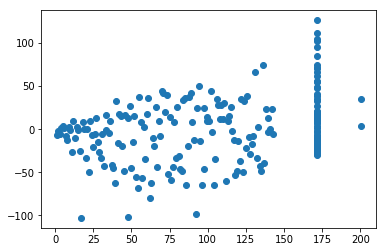

ADP vs actual


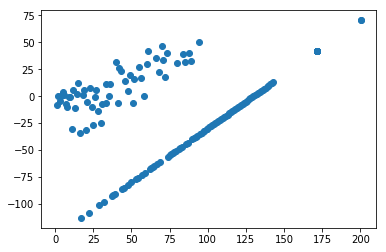

Points Last vs actual


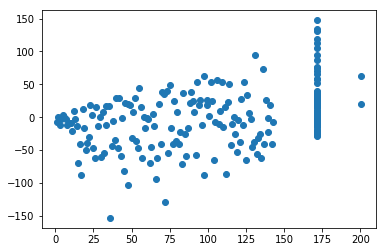

RB
model vs actual


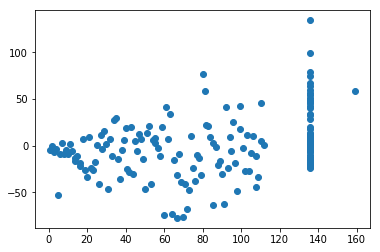

ADP vs actual


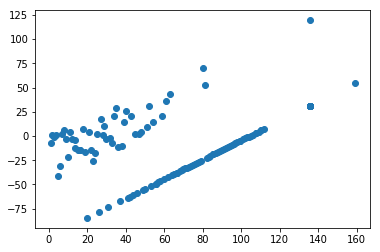

Points Last vs actual


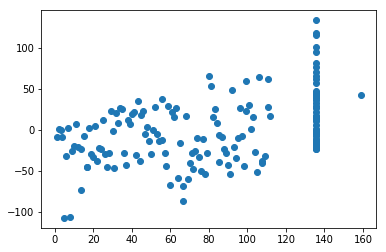

QB
model vs actual


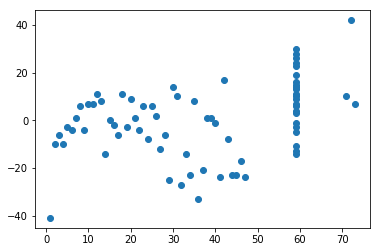

ADP vs actual


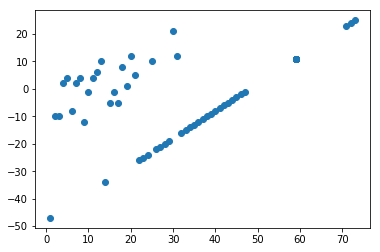

Points Last vs actual


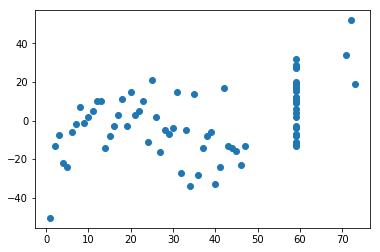

TE
model vs actual


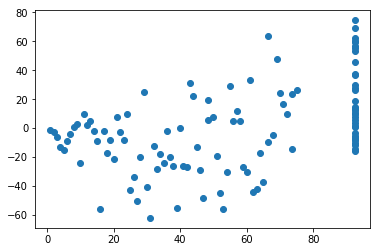

ADP vs actual


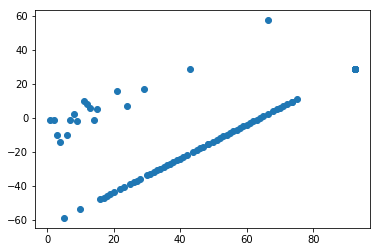

Points Last vs actual


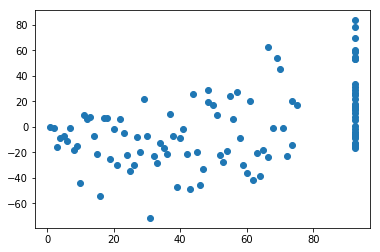

,Year,Pos,ADP_As_Predictor,Points_Last_As_Predictor,Model_As_Predictor
0,2017,WR,329132,423644,295307
1,2017,RB,163893,261282,182140
2,2017,QB,14508,22836.5,17404
3,2017,TE,72795,91830,94381


In [14]:
import matplotlib.pyplot as plt
final_dict = {}
output_dict = {}
for pos in predict_dict:
    names = predict_names[pos]
    actual_pts = predict_pts_next[pos]
    final_dict[pos] = predict_dict[pos]
    #print(frame)
    #print([x for x in list(final_dict[pos].columns) if x not in feature_list])
    model = model_dict[pos]
    final_dict[pos]['prediction'] = model.predict(final_dict[pos])
    final_dict[pos]['Names'] = names
    final_dict[pos]['pts_next_year'] = actual_pts
    
##### create R-Sq frame for results comparison #################################
results_frame = pd.DataFrame()
results_frame['Year'] = '_'
results_frame['Pos'] = '_'
results_frame['ADP_As_Predictor'] = '_'
results_frame['Points_Last_As_Predictor'] = '_'
results_frame['Model_As_Predictor'] = '_'

for pos in ['WR', 'RB', 'QB', 'TE']:
    results_frame.loc[len(results_frame), 'Year'] = predict_year
    results_frame.loc[len(results_frame) - 1, 'Pos'] = pos
    testtest = predict_dict[pos].sort_values(
        ['prediction'], ascending = False
    )[[
        'Names'
        , 'PPR'
        , 'Overall'
        , 'prediction'
        , 'pts_next_year']].reset_index(drop = True)
    testtest['Last_Year_Pos_Rank'] = testtest['PPR'].rank(ascending = False)
    testtest['ADP_Pos_Rank'] = testtest['Overall'].rank()
    testtest['Predicted_Pos_Rank'] = testtest['prediction'].rank(ascending = False)
    testtest['Actual_Next_Pos_Rank'] = testtest['pts_next_year'].rank(ascending = False)
    testtest['Rank_Diff'] = testtest['Actual_Next_Pos_Rank'] - testtest['Predicted_Pos_Rank']
    testtest['ADP_Diff'] = testtest['Actual_Next_Pos_Rank'] - testtest['ADP_Pos_Rank']
    testtest['Pts_Diff'] = testtest['Actual_Next_Pos_Rank'] - testtest['Last_Year_Pos_Rank']
    print(pos)
    plt.scatter(testtest['Actual_Next_Pos_Rank'], testtest['Rank_Diff'])
    print('model vs actual')
    plt.show()
    plt.scatter(testtest['Actual_Next_Pos_Rank'], testtest['ADP_Diff'])
    print('ADP vs actual')
    plt.show()
    plt.scatter(testtest['Actual_Next_Pos_Rank'], testtest['Pts_Diff'])
    print('Points Last vs actual')
    plt.show()
    
    val = sum((testtest['ADP_Pos_Rank'] - testtest['Actual_Next_Pos_Rank'])**2)
    results_frame.loc[len(results_frame) - 1, 'ADP_As_Predictor'] = val
    val = sum((testtest['Last_Year_Pos_Rank'] - testtest['Actual_Next_Pos_Rank'])**2)
    results_frame.loc[len(results_frame) - 1, 'Points_Last_As_Predictor'] = val
    val = sum((testtest['Predicted_Pos_Rank'] - testtest['Actual_Next_Pos_Rank'])**2)
    results_frame.loc[len(results_frame) - 1, 'Model_As_Predictor'] = val
    
results_frame

In [36]:
results_frame

,Year,Pos,ADP_As_Predictor,Points_Last_As_Predictor,Model_As_Predictor
0,2014,WR,501186,311406,372362
1,2014,RB,249860,252906,230696
2,2014,QB,28254.5,27323,24435.5
3,2014,TE,57119.5,59535,51264.5


In [33]:
results_frame

,Year,Pos,ADP_As_Predictor,Points_Last_As_Predictor,Model_As_Predictor
0,2015,WR,551888,569233,567572
1,2015,RB,328052,290372,282574
2,2015,QB,20454,25463,22896.5
3,2015,TE,78858,73796,82102


In [30]:
results_frame

,Year,Pos,ADP_As_Predictor,Points_Last_As_Predictor,Model_As_Predictor
0,2016,WR,527416,450948,433718
1,2016,RB,360445,313912,306126
2,2016,QB,19982,11933.5,13589
3,2016,TE,89377.5,76638.5,80467.5


In [27]:
results_frame

,Year,Pos,ADP_As_Predictor,Points_Last_As_Predictor,Model_As_Predictor
0,2017,WR,475329,435016,335336
1,2017,RB,218883,256080,197777
2,2017,QB,20606,22836.5,16512
3,2017,TE,89359,86984,103198


# Predict Next Year

In [93]:
#################### take out final year where pts next year are all NULL ###################
## chose the year one before, ex: want to predict for 2019 season choose 2018, last year of data
predict_year = 2018

#### replace na's with mean of column ###########################
model_dict = {}
predict_dict = {}
predict_names = {}
predict_pts_next = {}
for pos in pos_dict:
    print(pos)
    test = pos_dict[pos]

    test = test.replace(np.inf, 'NULL', regex=True)
    test = test.replace(-np.inf, 'NULL', regex=True)
    test = test.replace('NULL', np.nan)

    test = test.fillna(0)
    target = test[[x for x in test.columns if ('Rk' not in x) 
                   & ('FantPos' not in x)
                  & ('Pt' not in x)
                  & ('Tm_prev_year' not in x)
                  & ('2PP' not in x) & ('delta_ppg' not in x)
                  & ('ppg_next_year' not in x) & ('g_next_year' not in x)
                  & ('College' not in x) & ('Conf' not in x)
                  & ('Ht' not in x)]]
    
    ## ad in predict_set here, after a lot of the stuff. or take out year later most likely
    
    dum = pd.get_dummies(target.Tm)
    target = target[[x for x in target.columns if ('Tm' not in x)]]
    target = pd.concat([target, dum], axis=1)
    
    predict_names[pos] = target.loc[target.Year == predict_year]\
        .reset_index(drop = True)['Name']
    predict_pts_next[pos] = target.loc[target.Year == predict_year]\
        .reset_index(drop = True)['pts_next_year']
    predict_dict[pos] = target.loc[target.Year == predict_year]\
        .reset_index(drop = True)\
        .drop(['Year', 'pts_next_year', 'Name'], axis=1)
    target = target.loc[target.Year < predict_year]\
        .reset_index(drop = True)\
        .drop(['Year', 'Name'], axis=1)
    
    labels = target['pts_next_year']
    target = target.drop(['pts_next_year'], axis = 1)
    
    feature_list = list(target.columns)
    features = np.array(target)
    labels = np.array(labels)

    # Using Skicit-learn to split data into training and testing sets
    from sklearn.model_selection import train_test_split
    # Split the data into training and testing sets
    #train_features, test_features, train_labels, test_labels = train_test_split(features
     #                                                                           , labels
      #                                                                          , test_size = 0.25
       #                                                                         , random_state = 42)
#### instead do expanding window!! #########
    #train_features[train_features < -10000]
    # Import the model we are using
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf.fit(features, labels)
    model_dict[pos] = rf
    
    # Get numerical feature importances
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    

TE
Variable: Overall              Importance: 0.35
Variable: Std.Dev              Importance: 0.07
Variable: Tgt                  Importance: 0.06
Variable: ReYds                Importance: 0.06
Variable: PPR                  Importance: 0.04
Variable: Fant_Share           Importance: 0.04
Variable: Tgt_per_game         Importance: 0.03
Variable: Rec                  Importance: 0.02
Variable: ReYds/R              Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: ppg_this_year        Importance: 0.02
Variable: ReYds_per_R          Importance: 0.02
Variable: Rec_per_tgt          Importance: 0.02
Variable: ReTD_per_rec         Importance: 0.02
Variable: Win_PCT              Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: G                    Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: G_prev_year          Importance: 0.01
Variable: season_frac_1        Importance: 0.01
Variable: season_frac_2        Import

Variable: Overall              Importance: 0.36
Variable: Std.Dev              Importance: 0.15
Variable: PPR                  Importance: 0.03
Variable: ppg_this_year        Importance: 0.03
Variable: RuAtt_per_game       Importance: 0.03
Variable: ReYds                Importance: 0.02
Variable: PosRank              Importance: 0.02
Variable: Tgt_per_game         Importance: 0.02
Variable: Fant_Share           Importance: 0.02
Variable: Age                  Importance: 0.01
Variable: GS                   Importance: 0.01
Variable: RuAtt                Importance: 0.01
Variable: RuYds                Importance: 0.01
Variable: RuY/A                Importance: 0.01
Variable: RuTD                 Importance: 0.01
Variable: Tgt                  Importance: 0.01
Variable: Rec                  Importance: 0.01
Variable: ReYds/R              Importance: 0.01
Variable: Fmb                  Importance: 0.01
Variable: FL                   Importance: 0.01
Variable: VBD                  Importanc

In [94]:
final_dict = {}
output_dict = {}
for pos in predict_dict:
    names = predict_names[pos]
    actual_pts = predict_pts_next[pos]
    final_dict[pos] = predict_dict[pos]
    model = model_dict[pos]
    final_dict[pos]['prediction'] = model.predict(final_dict[pos])
    output_dict = final_dict
    output_dict[pos]['Names'] = names
    #final_dict[pos]['pts_next_year'] = actual_pts
    output_dict[pos][['Names', 'prediction', 'PPR']]
##### create R-Sq frame for results comparison #################################



In [103]:
output_dict['TE'][['Names', 'prediction', 'Overall', 'PPR', 'Win_PCT']]\
.sort_values('prediction', ascending = False)\
.to_csv('test.csv', index = False)

output_dict['TE'].sort_values('prediction', ascending = False)[['Names', 'prediction', 'Overall', 'PPR', 'Win_PCT']]

,Names,prediction,Overall,PPR,Win_PCT
40,Travis Kelce,243.9703,16.8,294.6,75.0
57,Zach Ertz,211.6044,34.6,280.3,56.2
45,George Kittle,200.9350,30.0,258.7,25.0
93,Austin Hooper,156.9258,102.5,163.0,43.8
87,David Njoku,156.3198,85.2,143.9,46.7
36,Mark Andrews,155.8042,142.7,107.2,62.5
11,Jared Cook,152.0251,70.7,193.6,25.0
84,Vance McDonald,150.3660,77.1,133.0,60.0
13,Jimmy Graham,134.8697,156.6,130.6,40.0
24,Trey Burton,133.7132,158.2,147.1,75.0
